In [48]:
import utils
from os.path import join
import pandas as pd
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json

In [2]:
dt = utils.DirectoryTree("data/Category and Attribute Prediction Benchmark/")

In [3]:
dt.Anno.list_files()

['list_category_img.txt',
 'list_bbox.txt',
 'list_attr_cloth.txt',
 'list_landmarks.txt',
 'list_attr_img.txt',
 'list_category_cloth.txt']

In [88]:
# Load data
with open(join(dt.Eval.path, 'list_eval_partition.txt'), 'r') as f:
    num_rows = int(f.readline().rstrip("\n"))
    columns = f.readline().rstrip("\n").split("  ")
    my_dict = {c : [] for c in columns}
    for i in tqdm(range(num_rows)):
        # sample = f.readline().rstrip("\n").split("                       ")
        sample = f.readline().strip(" ").rstrip("\n").split(" ")
        sample = [e for e in sample if e != ""]
        assert len(sample) == len(columns), "%s"% (sample)
        for j, c in enumerate(columns):
            my_dict[c].append(sample[j])
eval_status = my_dict['evaluation_status']
status_img_names = my_dict['image_name']

with open(join(dt.Anno.path, 'list_bbox.txt'), 'r') as f:
    num_rows = int(f.readline().rstrip("\n"))
    columns = f.readline().rstrip("\n").split("  ")
    assert columns == ['image_name', 'x_1', 'y_1', 'x_2', 'y_2'], "%s"%str(columns)
    my_dict = {c : [] for c in columns}
    for i in tqdm(range(num_rows)):
        # sample = f.readline().rstrip("\n").split("                       ")
        sample = f.readline().strip(" ").rstrip("\n").split(" ")
        sample = [e for e in sample if e != ""]
        img_name = sample[0]
        left, right, top, bottom = np.array(list(map(int, sample[1:])))
        sample = [img_name, left, right, top, bottom]
        assert len(sample) == len(columns), "%s"% (sample)
        for j, c in enumerate(columns):
            my_dict[c].append(sample[j])
bbox_coords = np.concatenate([[my_dict['x_1']], [my_dict['x_2']], [my_dict['y_1']], [my_dict['y_2']]], axis = 0).T
bbox_img_names = my_dict['image_name']

with open(join(dt.Anno.path, 'list_category_img.txt'), 'r') as f:
    num_rows = int(f.readline().rstrip("\n"))
    columns = f.readline().rstrip("\n").split("  ")
    my_dict = {c : [] for c in columns}
    for i in tqdm(range(num_rows)):
        # sample = f.readline().rstrip("\n").split("                       ")
        sample = f.readline().strip(" ").rstrip("\n").split(" ")
        sample = [e for e in sample if e != ""]
        assert len(sample) == len(columns), "%s"% (sample)
        for j, c in enumerate(columns):
            my_dict[c].append(sample[j])
cat_labels = list(map(lambda id: int(id) - 1, my_dict['category_label']))
cat_img_names = my_dict['image_name']

with open(join(dt.Anno.path, 'list_attr_cloth.txt'), 'r') as f:
    num_rows = int(f.readline().rstrip("\n"))
    columns = f.readline().rstrip("\n").split("  ")
    assert columns == ['attribute_name', 'attribute_type'], "%s"%str(columns)
    my_dict = {c : [] for c in columns}
    for i in tqdm(range(num_rows)):
        # sample = f.readline().rstrip("\n").split("                       ")
        sample = f.readline().strip(" ").rstrip("\n").split(" ")
        sample = [e for e in sample if e != ""]
        attr_type = int(sample[-1])
        attr_name = "_".join(sample[:-1])
        sample = [attr_name, attr_type]
        for j, c in enumerate(columns):
            my_dict[c].append(sample[j])

attr_names = my_dict['attribute_name']
attr_types = my_dict['attribute_type']
attr_index = {i: name for i, name in enumerate(attr_names)}
assert len(attr_index) == 1000

with open(join(dt.Anno.path, 'list_category_cloth.txt'), 'r') as f:
    num_rows = int(f.readline().rstrip("\n"))
    columns = f.readline().rstrip("\n").split("  ")
    assert columns == ['category_name', 'category_type'], "%s"%str(columns)
    my_dict = {c : [] for c in columns}
    for i in tqdm(range(num_rows)):
        # sample = f.readline().rstrip("\n").split("                       ")
        sample = f.readline().strip(" ").rstrip("\n").split(" ")
        sample = [e for e in sample if e != ""]
        cat_type = int(sample[-1])
        cat_name = "_".join(sample[:-1])
        sample = [cat_name, cat_type]
        for j, c in enumerate(columns):
            my_dict[c].append(sample[j])
cat_names = my_dict['category_name']
cat_types = my_dict['category_type']
cat_index = {i: name for i, name in enumerate(cat_names)}
assert len(cat_index) == 50

with open(join(dt.Anno.path, 'list_attr_img.txt'), 'r') as f:
    num_rows = int(f.readline().rstrip("\n"))
    columns = f.readline().rstrip("\n").split("  ")
    my_dict = {c : [] for c in columns}
    for i in tqdm(range(num_rows)):
        # sample = f.readline().rstrip("\n").split("                       ")
        sample = f.readline().strip(" ").rstrip("\n").split(" ")
        sample = [e for e in sample if e != ""]
        assert len(sample[1:]) == 1000, "%s"% (sample)
        img_name = sample[0]
        attr_vec = np.array(sample[1:]).astype(int)
        attr_vec = attr_vec * (attr_vec > 0)
        sample = [img_name, attr_vec]
        for j, c in enumerate(columns):
            my_dict[c].append(sample[j])
    
    attr_labels = my_dict['attribute_labels']
    attr_img_names = my_dict['image_name']

assert (bbox_img_names == cat_img_names) \
        and (attr_img_names == cat_img_names) \
        and (bbox_img_names == status_img_names), "Image names from categories, attributes, bboxes, and eval status should be the same"
img_names = cat_img_names

100%|██████████| 289222/289222 [03:03<00:00, 1573.30it/s]


In [1]:
# Plot 16 sample images with catgeory and top 2 attributes
N = 16
idx = np.arange(len(img_names))
idx = np.random.choice(idx, N)
path = [join(dt.Img.path, img_names[i]) for i in idx]
cat = [cat_index[cat_labels[i]] for i in idx]
attr = [[attr_index[j] for j in np.arange(1000)[attr_labels[i] > 0]] for i in idx]
box = [[bbox_coords[i][0], bbox_coords[i][2], bbox_coords[i][1], bbox_coords[i][3]] for i in idx]

fig, axes = plt.subplots(4, 4, figsize = (25, 24))
axes = axes.flatten()
for i, (p, b, c, a) in enumerate(zip(path, box, cat, attr)):
    img = Image.open(p)
    img = img.crop(b)
    axes[i].imshow(np.array(img))
    axes[i].set_title("%s \n %s"%(str(c), str(a[:2])))

NameError: name 'np' is not defined

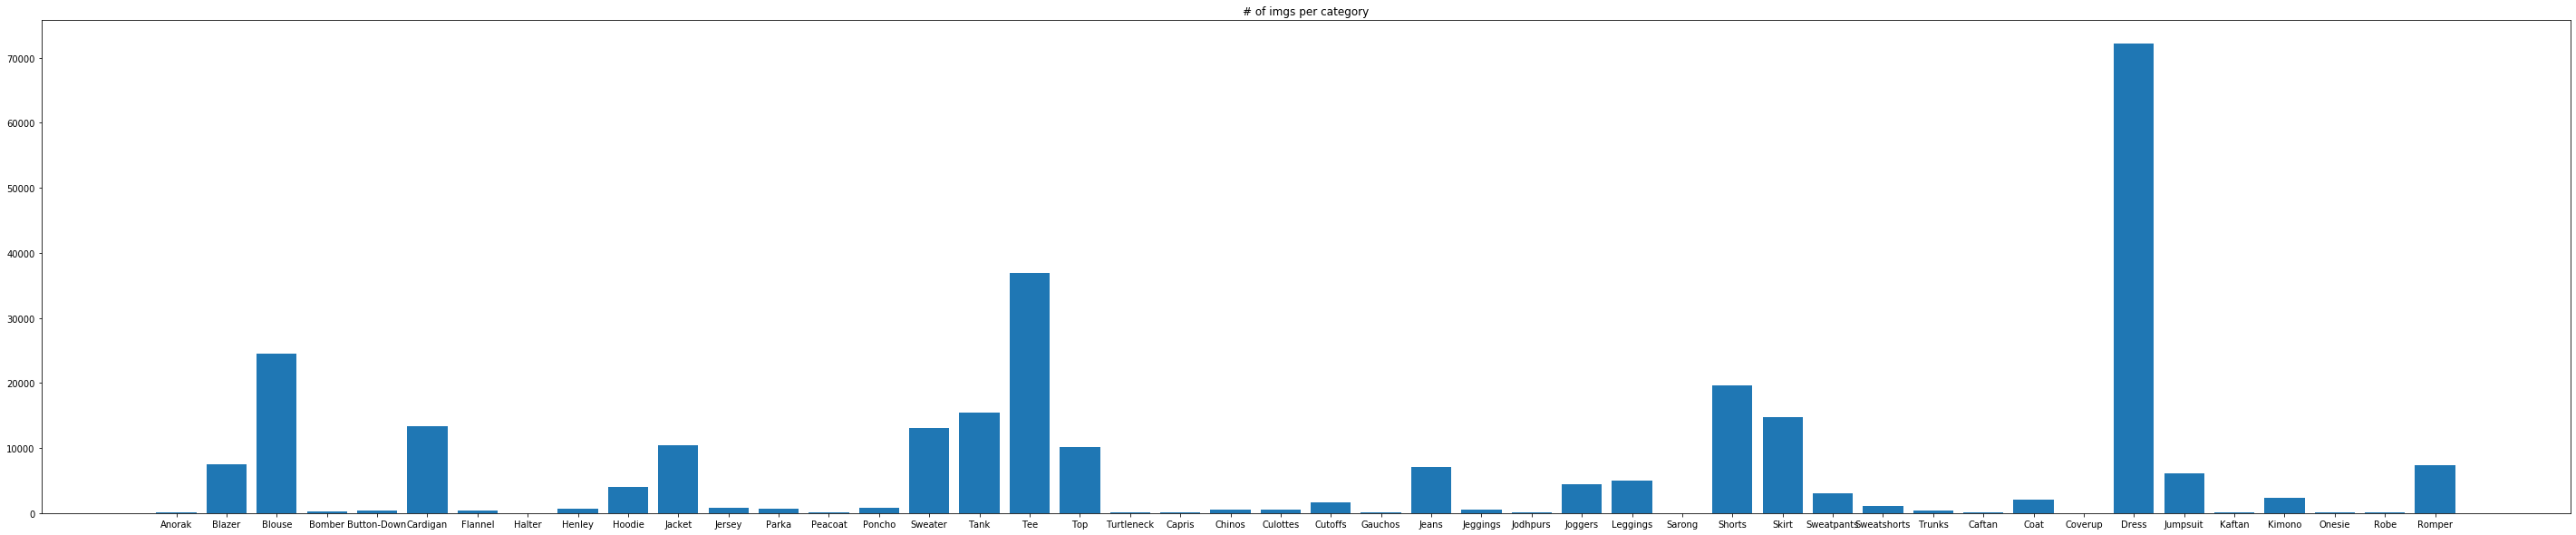

In [61]:
# Plot number of images per category
cat_ids, counts = np.unique(cat_labels, return_counts = True)
cats = [cat_index[cid] for cid in cat_ids]
fig = plt.figure(figsize = (50, 10))
plt.bar(cats, counts)
plt.title("# of imgs per category")
plt.show()

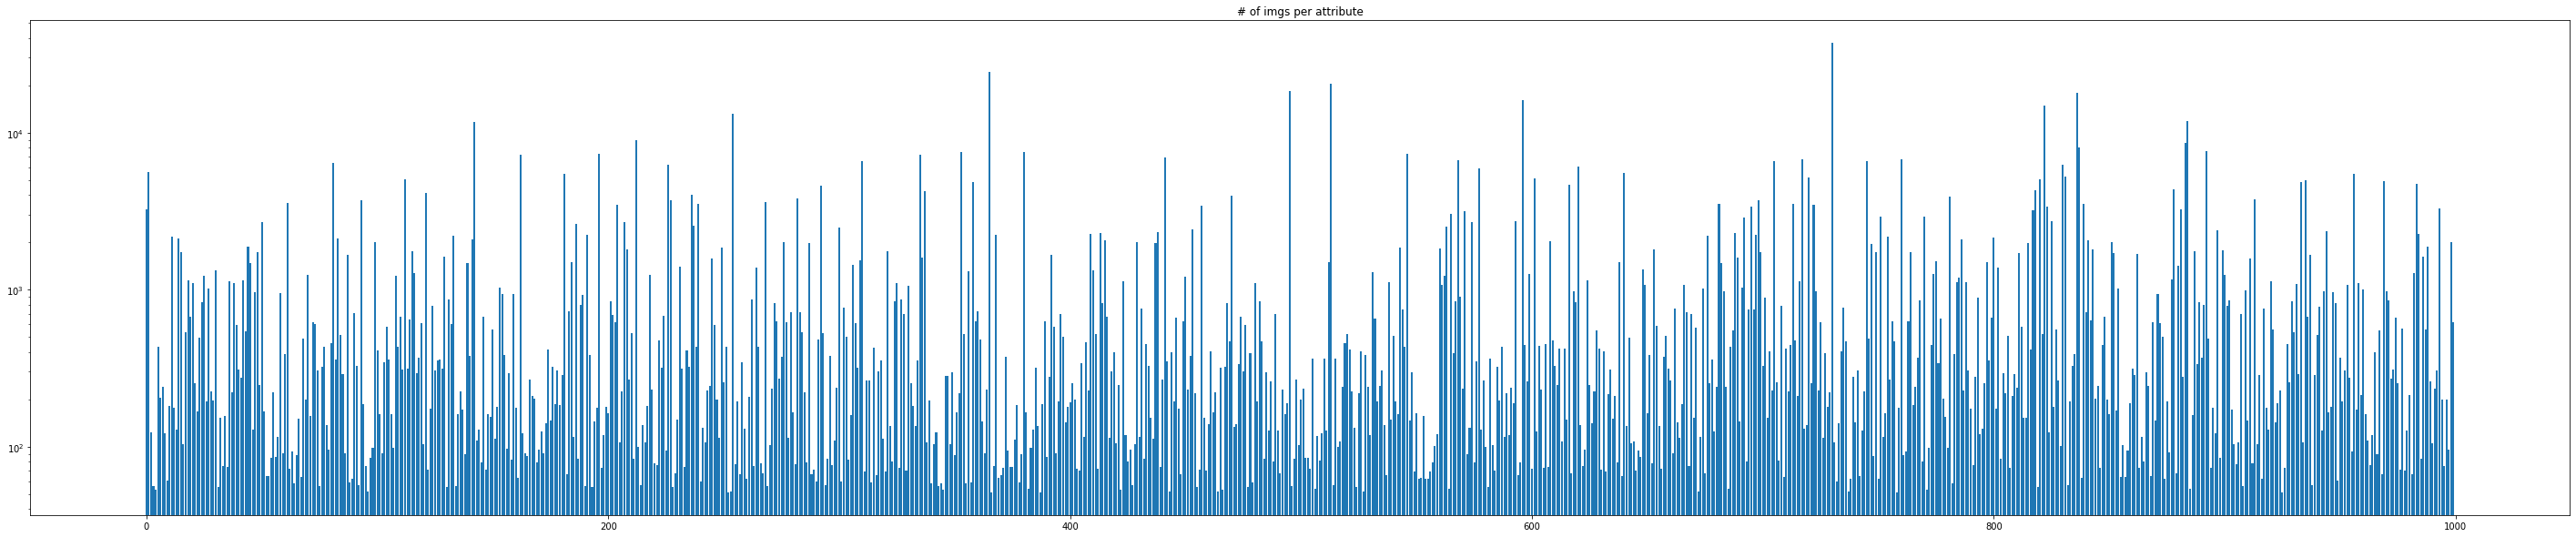

In [72]:
# Plot number of images per attribute
counts = np.sum(np.array(attr_labels), axis = 0)
fig = plt.figure(figsize = (50, 10))
plt.bar(np.arange(1000, ), counts)
plt.title("# of imgs per attribute")
plt.yscale('log')
plt.show()

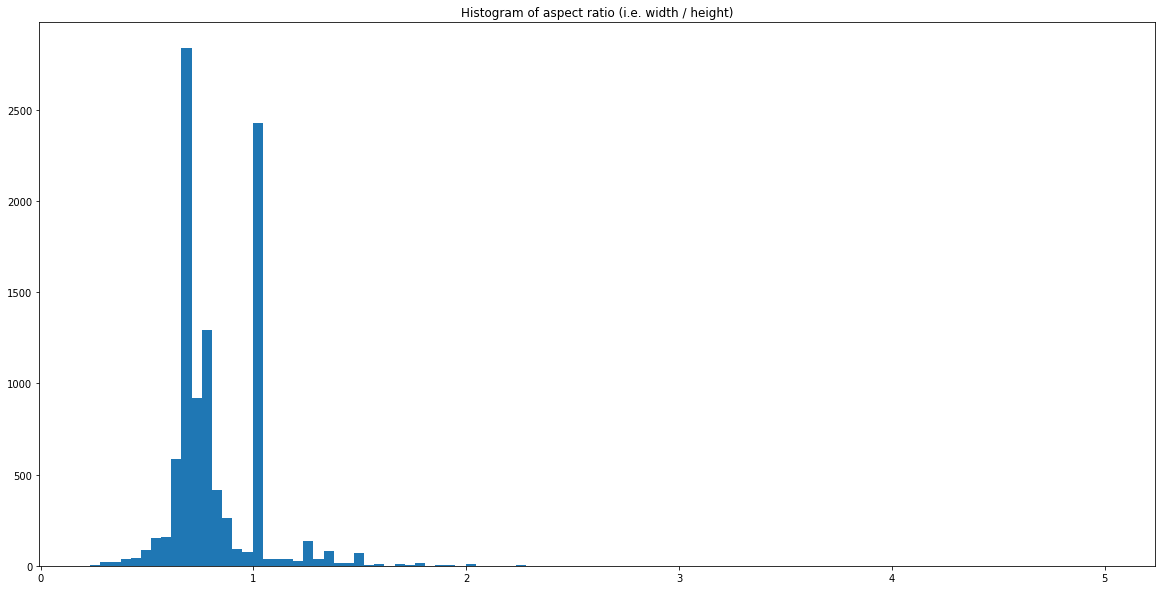

In [82]:
N = 10000
idx = np.arange(len(img_names))
idx = np.random.choice(idx, N)
path = [join(dt.Img.path, img_names[i]) for i in idx]
cat = [cat_index[cat_labels[i]] for i in idx]
attr = [[attr_index[j] for j in np.arange(1000)[attr_labels[i] > 0]] for i in idx]
box = [[bbox_coords[i][0], bbox_coords[i][2], bbox_coords[i][1], bbox_coords[i][3]] for i in idx]
aspect = []
for p in path:
    img = Image.open(p)
    w, h = img.size
    aspect.append(w / h)
_, axes = plt.subplots(1, 1, figsize=(20,10))
axes.hist(aspect, bins = 100)
axes.set_title("Histogram of aspect ratio (i.e. width / height)")
plt.show()

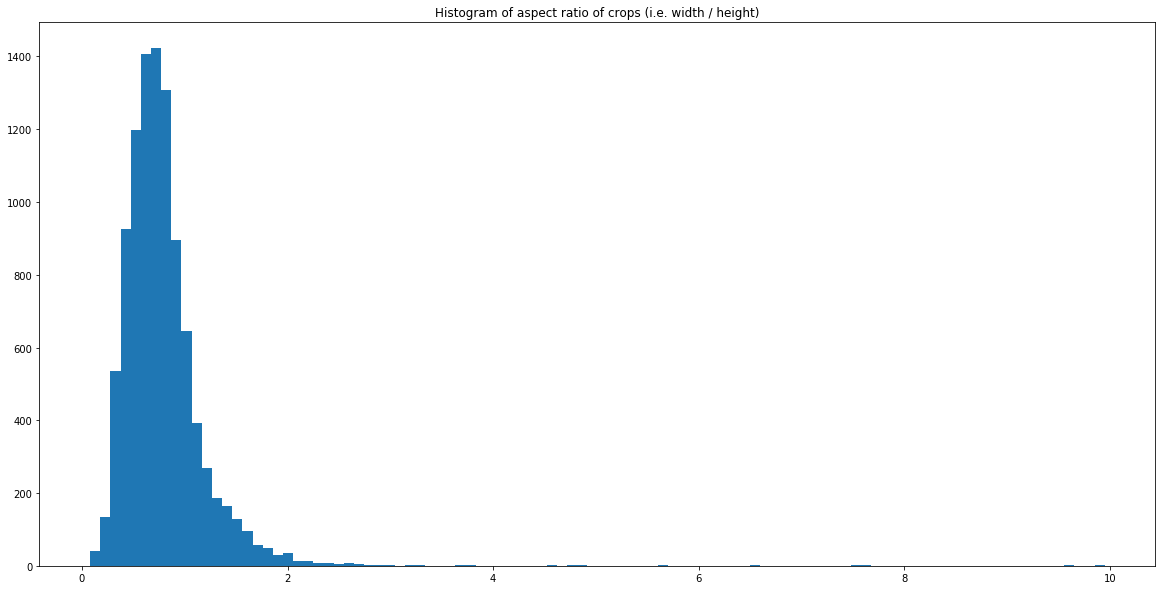

In [84]:
N = 10000
idx = np.arange(len(img_names))
idx = np.random.choice(idx, N)
path = [join(dt.Img.path, img_names[i]) for i in idx]
cat = [cat_index[cat_labels[i]] for i in idx]
attr = [[attr_index[j] for j in np.arange(1000)[attr_labels[i] > 0]] for i in idx]
box = [[bbox_coords[i][0], bbox_coords[i][2], bbox_coords[i][1], bbox_coords[i][3]] for i in idx]
aspect = []
for p, b in zip(path, box):
    img = Image.open(p)
    img = img.crop(b)
    w, h = img.size
    aspect.append(w / h)
_, axes = plt.subplots(1, 1, figsize=(20,10))
axes.hist(aspect, bins = 100)
axes.set_title("Histogram of aspect ratio of crops (i.e. width / height)")
plt.show()

In [90]:
save_dict = {'img_names':img_names,
             'cat_labels':cat_labels,
             'attr_labels':list(map(lambda al: al.tolist(), attr_labels)),
             'cat_index':cat_index,
             'attr_index':attr_index, 
             'bbox_coords':bbox_coords.tolist(),
             'eval_status':eval_status}

In [91]:
with open(join(dt.Anno.path, 'meta.json'), 'w') as f:
    json.dump(save_dict, f)